# EXO1


Partons de l'exercice 3 (à faire de préférence avant)

- Expliciter et expliquer l'hypothèse faite lors de la construction du classifieur. En particulier, chaque pixel est considéré comme une     variable aléatoire et donc une image comme la réalisation d'un vecteur aléatoire. Quelle hypothèse est faite sur la dépendance entre les pixels ? Quel est l'impact sur la matrice de covariance ?


- Proposer une mesure permettant d'évaluer cette hypothèse.


- Évaluons cette hypothèse en considérant comme voisinage pour chaque pixel, son voisin de gauche et de droite.


- Si nous faisions l'hypothèse qu'un pixel ne dépend que de ses voisins immédiats de gauche et de droite, écrire les paramètres à estimer et comment les estimer. On pourra se contenter de dépendances simples: si une image est un vecteur, un pixel (une composante du vecteur) dépend du pixel avant et après dans le vecteur; pour les pixels sur les bords du vecteurs peuvent être ignoré si besoin.


- BONUS: Coder et expérimenter ce modèle


Pour répondre à l'avant dernière question, une solution est de considérer que la probabilité d'une image est la probabilité jointe sur l'ensemble des pixels. Sans hypothèse, cette probabilité se décompose avec la règle de la chaine. Puis il est possible d'introduire les hypothèses d'indépendance.


In [18]:
import pickle, gzip
import numpy as np
import math
import operator
# Load the dataset
f = gzip.open('./mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, valid_set, test_set = p
labels = train_set[1]
# K = nombre de classes
K = 10  
    
# Calcule priors
priors = {}
for k in range(K):
    priors[k] = np.log(len(labels[labels == k]) / len(labels))
    
# binarise les images
def mk_bin(images):
    res = []
    for img in images:
        tmp = np.zeros(img.shape)
        tmp[img > 0.5] = 1
        res.append(tmp)
    return np.asarray(res)

images = mk_bin(train_set[0])
labels = train_set[1]
images_test = mk_bin(test_set[0])
labels_test = test_set[1]
beta = np.ndarray((K, 784, 2, 2))



# calcul de l'estimation
for y, img in enumerate(images):
    #beta[labels[y]] += img
    for i in range(1, len(img) - 1):
        x_i_m = int(img[i - 1])
        x_i_p = int(img[i + 1])
        beta[labels[y],i,x_i_m,x_i_p] += img[i]
for k in range(K):
    beta[k,:,0,0] /= beta[k,:,0,0].sum()
    beta[k,:,1,0] /= beta[k,:,1,0].sum()
    beta[k,:,0,1] /= beta[k,:,0,1].sum()
    beta[k,:,1,1] /= beta[k,:,1,1].sum()

    
    
# Prediction avec la formule naive bayes
#def predict_naive_bayes(img, beta):
#    naive_bayes = {}
#    for k in range(K):
#        p_Y_eq_y = priors[k]
#        non_null = beta[k] != 0
#        xi = img[non_null]
#        piiy = beta[k][non_null]
#        tmp = (xi * np.log(piiy) + (1-xi) * np.log(1-piiy) ).sum()
#        naive_bayes[k] = tmp + p_Y_eq_y
#    return naive_bayes


# Prediction avec la formule naive bayes
def predict_naive_bayes(img, beta):
    naive_bayes = {}
    for k in range(K):
        p_Y_eq_y = priors[k]
        tmp = 0#0(x * np.log(pi[]) + (1-x) * np.log(1-pi) ).sum()
        for i in range(1, len(img) - 1):
            x_i_m = int(img[i - 1])
            x_i_p = int(img[i + 1])
            piiy = beta[k,i,x_i_m,x_i_p]
            if piiy == 0:
                continue
            tmp += img[i] * math.log(piiy) + (1 - img[i]) * math.log(1-piiy)
        naive_bayes[k] = tmp + p_Y_eq_y
    return naive_bayes


# Evaluation du modele
loss = 0.
for i in range(len(test_set[0][:1000])):
    pred = predict_naive_bayes(test_set[0][i], beta)
    res = max(pred.items(), key=operator.itemgetter(1))[0]
    loss += 1 if res != test_set[1][i] else 0
loss /= len(test_set[1])
print("% de mauvaises réponses :",loss * 100)



# lissage
alpha = 1e-9
beta = np.ndarray((10,784,2,2))
for y, img in enumerate(images):
    for i in range(1, len(img) - 1):
        x_i_m = int(img[i - 1])
        x_i_p = int(img[i + 1])
        beta[labels[y],i,x_i_m,x_i_p] += img[i] + alpha
for k in range(10):
    beta[k,:,0,0] /= beta[k,:,0,0].sum() + K * alpha
    beta[k,:,1,0] /= beta[k,:,1,0].sum() + K * alpha
    beta[k,:,0,1] /= beta[k,:,0,1].sum() + K * alpha
    beta[k,:,1,1] /= beta[k,:,1,1].sum() + K * alpha
    
# Evaluation du modele (lissage)
loss = 0.
for i in range(len(test_set[0][:1000])):
    pred = predict_naive_bayes(test_set[0][i], beta)
    res = max(pred.items(), key=operator.itemgetter(1))[0]
    loss += 1 if res != test_set[1][i] else 0
loss /= len(test_set[1])
print("% de mauvaises réponses (lissage avec α = 1e-9 ) :",loss * 100)

% de mauvaises réponses : 7.340000000000001
% de mauvaises réponses (lissage avec α = 1e-9 ) : 4.6899999999999995


# EXO2

Repartons du TP sur Bayésien Naif Gaussien appliqué aux images MNIST.

Le classifieur vu en TP considère la réalisation un pixel conditionnellement à une classe comme une variable aléatoire gaussienne.

- Prenez les images de la classe 4, prendre 5 pixels avec une forte variance et tracer pour chacun la répartition des valeurs avec un histogramme.


- Faites la même chose pour la classe 5.


- Commenter les résultats obtenus

Supposons maintenant que la valeur d'un pixel conditionnellement à sa classe est en fait une variable aléatoire dont la distribution est donné par le mélange de 2 gaussiennes:

        Xi|Y=y∼αi,y,1N(μi,y,1,σi,y,1)+αi,y,2N(μi,y,2,σi,y,2)
        p(xi|y)=αi,y,1p1(x|y)+αi,y,2p2(x|y),

avec p1(x|y)=N(μi,y,1,σi,y,1). La distribution est en fait l'interpolation linéaire de 2 gaussiennes, et :
    αi,y,1+αi,y,2=1
La question qui se pose est comment calculer les paramètres de ce nouveau modèle pour une classe y donnée, à savoir :

        (αi,y,1,αi,y,2,μi,y,1,μi,y,2,σi,y,1,σi,y,2)

et nous allons voir comment au travers des questions suivantes.

Prenons par exemple les images de la classe 5 et un pixel du centre de l'image (par exemple un des pixels que vous avez sélectionné dans une des questions précédentes). Dans le cas à une seule gaussienne, chaque réalisation contribue à l'estimation des statistiques nécessaires (μ,σ).
Avec 2 gaussiennes, on ne sais pas à gaussienne, une observation va contribuer. Mais on peut calculer cette contribution, si on connait et fixe les paramètres.

- Proposer une fonction permettant de calculer la contribution d'une réalisation à chacune des gaussienne. Sachant que la somme des deux contributions est 1 et qu'elles dépendent de αi,y,1,αi,y,1,p1,p2.


- Une fois connue cette contribution, il est possible de mettre à jour les paramètres, puisque l'on sait pour chaque réalisation, de combien elle participe à chaque gaussienne. Une fois les contribution de chaque réalisation calculée sur les données d'apprentissage, écrire la formule d'estimation des paramètres pour

        (αi,y,1,αi,y,2,μi,y,1,μi,y,2,σi,y,1,σi,y,2).

Ainsi, si les paramètres sont connus, il est possible de calculer les contributions de chaque exemple, puis de recalculer les paramètres. Ainsi l'algorithme d'apprentissage est itératif:

- 0 : initialisation des contributions (tirage au hasard entre les deux gaussiennes)
- 1 : Calcul des paramètres.
- 2 : Calcul des contributions et retour à l'étape 1

Cet algorithme s'appelle E.M, et vous allez l'implémenter avec 2 fonctions à coder et à tester.

- Partir des données MNIST et les images de la classe 5, estimer les paramètres du mélange, visualiser la distribution obtenues pour les pixels sélectionnés et comparer cette fonction à l'histogramme des valeurs.


- Recommencer avec plusieurs initialisations aléatoires pour comparer les résultats. Sont-ils stables ?


- Faire de même avec la classe 4


- BONUS : coder un classifier qui utilise un mélange de 2 gaussiennes pour modéliser Xi|Y , évaluer ses performances et comparer avec le classifieur de base.

# Réponses

- Proposer une fonction permettant de calculer la contribution d'une réalisation à chacune des gaussienne. Sachant que la somme des deux contributions est 1 et qu'elles dépendent de αi,y,1,αi,y,1,p1,p2.

    - p(Xi | Y) = α1 * N(U(i,y,1), SIG(i, y, 1)) / (α1 * N(U(i,y,1), SIG(i, y, 1)) + α2 * N(U(i,y,2), SIG(i, y, 2)))

- Une fois connue cette contribution, il est possible de mettre à jour les paramètres, puisque l'on sait pour chaque réalisation, de combien elle participe à chaque gaussienne. Une fois les contribution de chaque réalisation calculée sur les données d'apprentissage, écrire la formule d'estimation des paramètres pour
    (αi,y,1,αi,y,2,μi,y,1,μi,y,2,σi,y,1,σi,y,2).
    
    - maj des affectations aux deux gaussiennes -> calcul de μ et σ selon cette nouvelle répartition au sein d'une classe

Win Rate : 77.63 %
------------0-------------


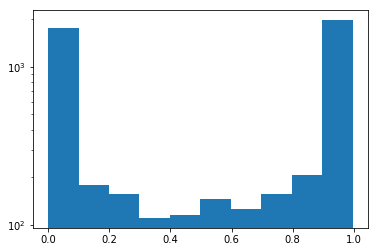

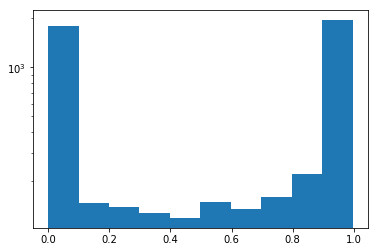

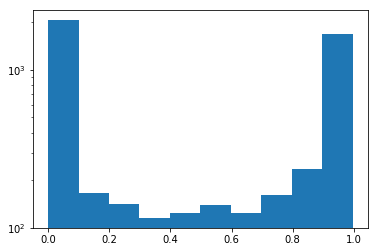

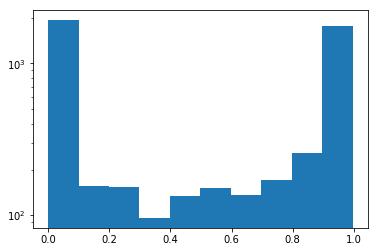

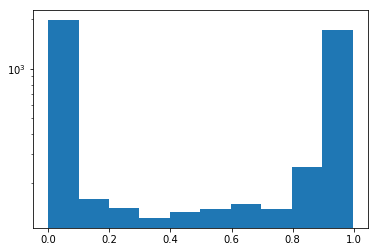

------------1-------------


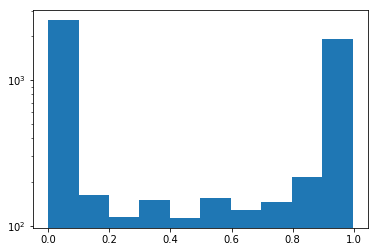

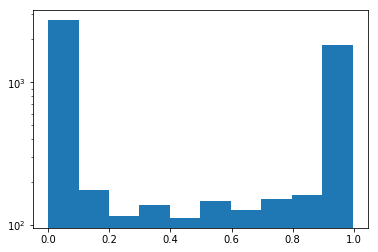

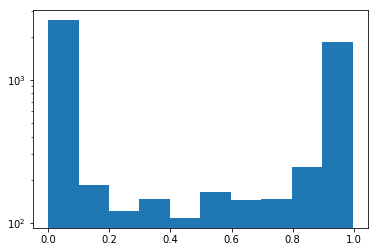

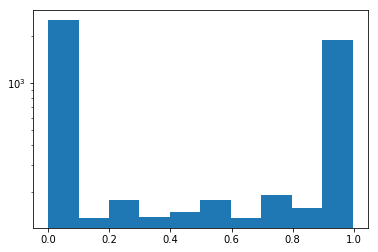

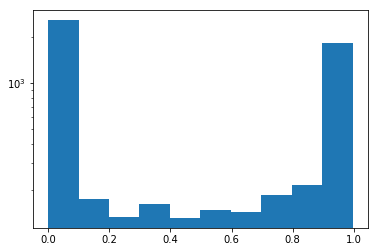

------------2-------------


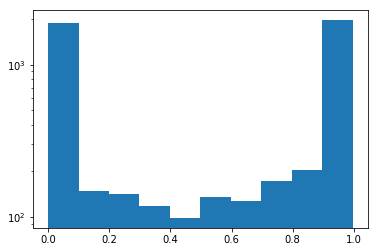

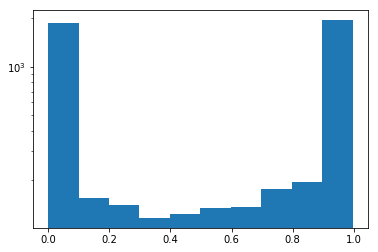

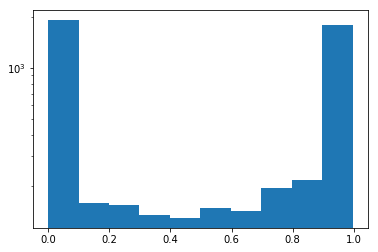

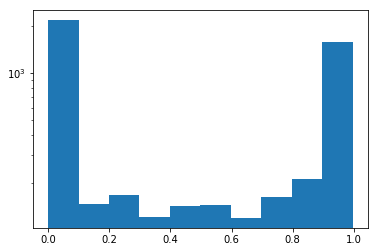

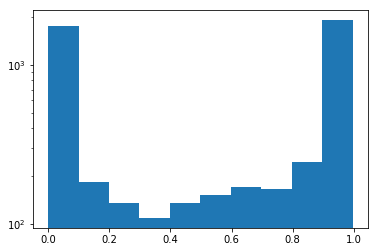

------------3-------------


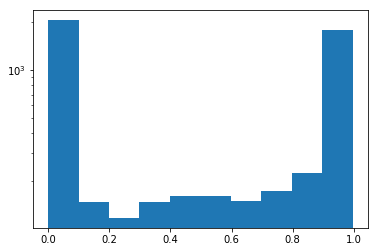

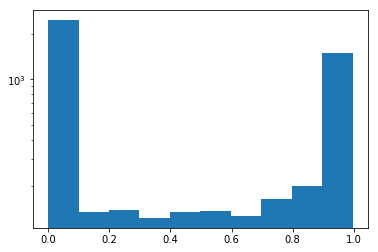

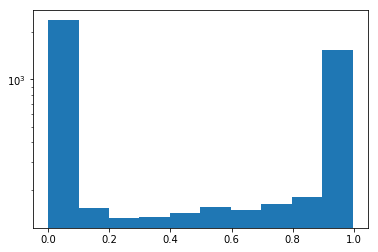

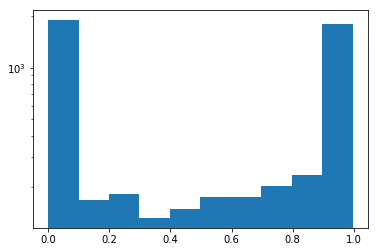

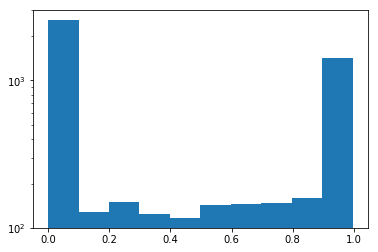

------------4-------------


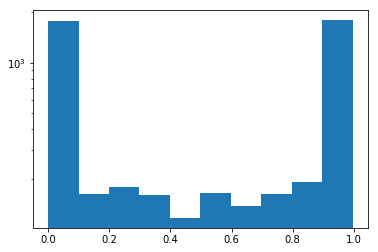

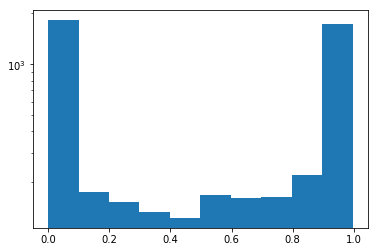

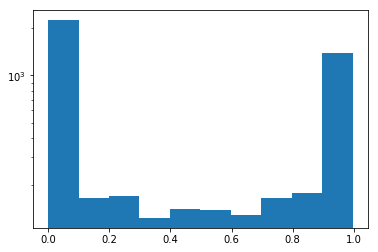

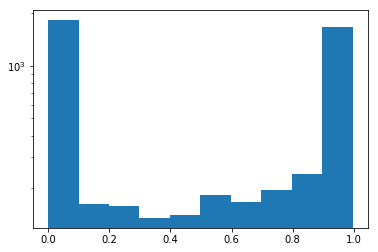

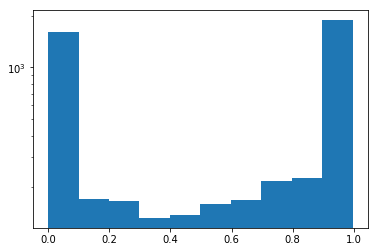

------------5-------------


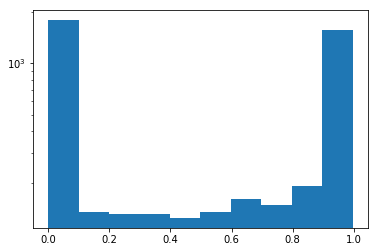

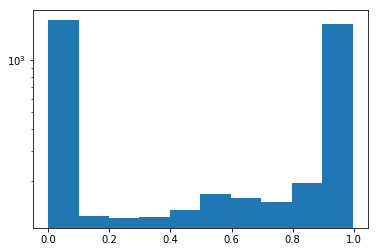

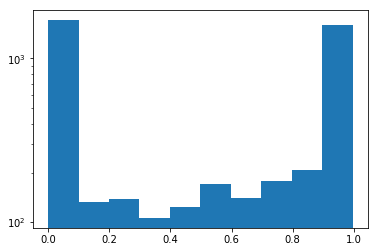

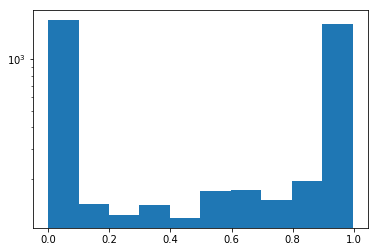

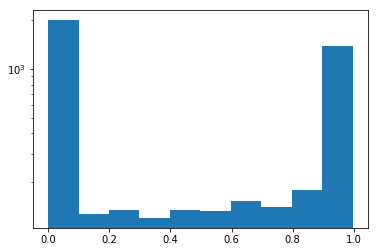

------------6-------------


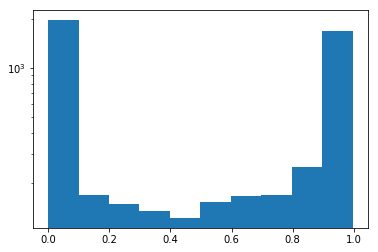

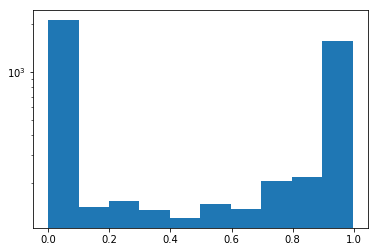

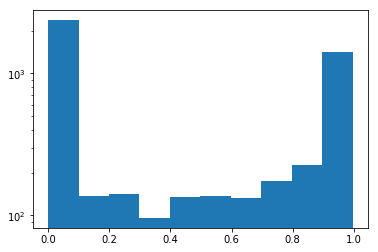

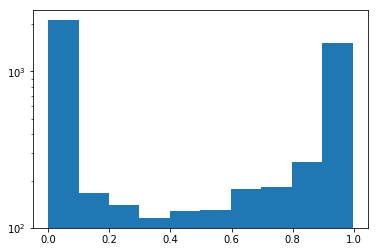

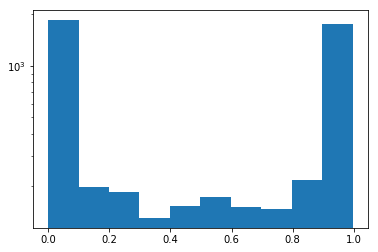

------------7-------------


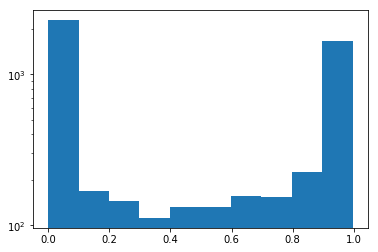

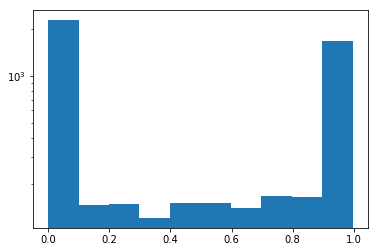

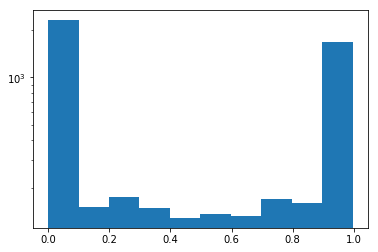

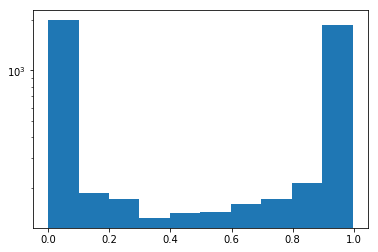

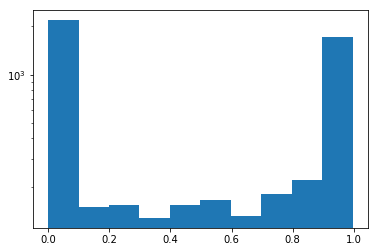

------------8-------------


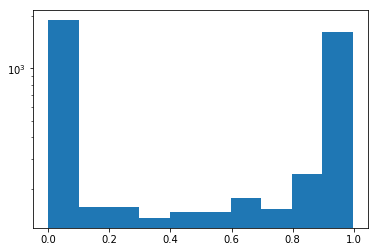

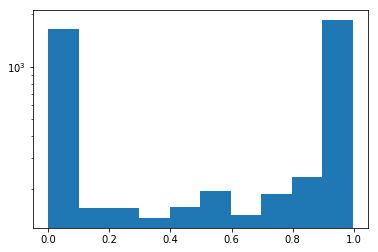

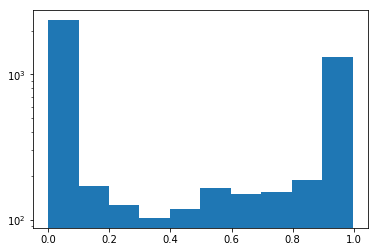

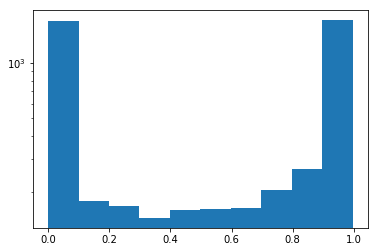

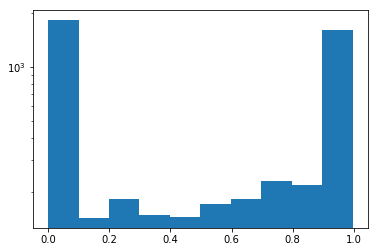

------------9-------------


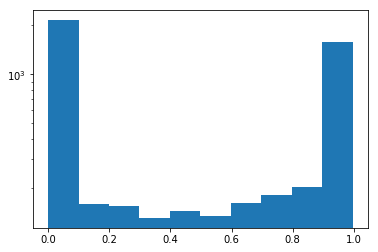

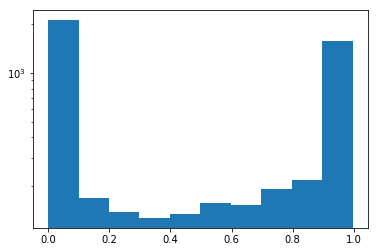

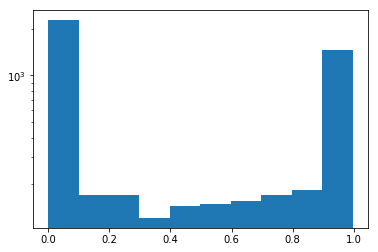

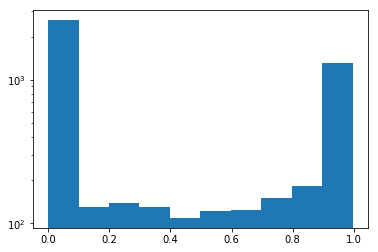

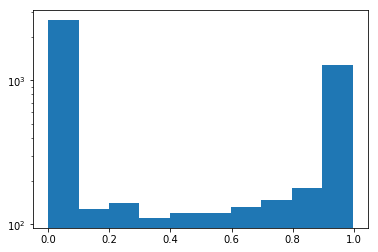

In [52]:
import pickle, gzip
import numpy as np
import math
import operator
# Load the dataset
f = gzip.open('./mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, valid_set, test_set = p

# K = nombre de classes

# Récupération des images et des labels
images = train_set[0]
labels = train_set[1]

#Correction professeur
means = {}
variances = {}
priors = {}

for i in range(0, 10):
    means[i]     = images[labels==i].mean(axis=0)
    variances[i] = images[labels==i].var(axis=0)
    priors[i]    = len(images[labels==i])/len(images)
        
def computePosteriors(image,means,variances,priors):
    posteriors = np.zeros([10,1])
    for lbl in range(10):
        mean = means[lbl]
        sigma2 = variances[lbl]
        non_null = sigma2!=0
        
        scale = 0.5*np.log(2*sigma2[non_null]*math.pi)
        expterm = -0.5*np.divide(np.square(image[non_null]-mean[non_null]), sigma2[non_null])
        
        llh = (expterm - scale).sum()
        post = llh + np.log(priors[lbl])
        posteriors[lbl]=post
    return posteriors

def winrate(images_test,labels_test):
    res = 0
    for i in range(len(images_test)):
        l = list(computePosteriors(images_test[i],means,variances,priors))
        res += 1 if labels_test[i] != l.index(max(l)) else 0
        
    return 1-(res/len(images_test))

images_test = test_set[0]
labels_test = test_set[1]

def getMax(array,nb):
    res = np.zeros(nb)
    for i in range(nb):
        max = np.argmax(array)
        res[i] = max
        array[max] = 0
    return res
    
    
def getline(array,line):
    res = np.zeros(int(array.size/array[0].size))
    for i in range(res.size):
        res[i] = array[i][int(line)]
            
    return res
    
    

print("Win Rate : " + str(winrate(images_test,labels_test)*100) + " %")

import matplotlib.pyplot as plt


for j in range(10):
    var = variances[j]
    M = getMax(var,5)
    print("------------"+str(j)+"-------------")
    for i in M:    
        plt.hist(getline(images[labels == j], i), log=True)
        plt.show()
    


# EXO3 Bayésien naïf discret

Reprendre la même tâche mais en binarizant les images. Pour cela, le modèle de chaque pixel est une binomiale. 

## TODO
- Quels sont les paramètres à estimer pour chaque classe ? 
- Comment les stockés ? 
- Implémenter l'estimation, puis l'inférence. (On peut dans un premier temps réutiliser l'implémentation existante de Sklearn)


In [4]:
import pickle, gzip
import numpy as np
import math
import operator
# Load the dataset
f = gzip.open('./mnist.pkl.gz', 'rb')
u = pickle._Unpickler(f)
u.encoding = 'latin1'
p = u.load()
train_set, valid_set, test_set = p
labels = train_set[1]
# K = nombre de classes
K = 10  
    
# Calcule priors
priors = {}
for k in range(K):
    priors[k] = np.log(len(labels[labels == k]) / len(labels))
    
# binarise les images
def mk_bin(images):
    res = []
    for img in images:
        tmp = np.zeros(img.shape)
        tmp[img > 0.5] = 1
        res.append(tmp)
    return np.asarray(res)

images = mk_bin(train_set[0])
labels = train_set[1]
images_test = mk_bin(test_set[0])
labels_test = test_set[1]
beta = np.ndarray((K, 784))



# calcul de l'estimation
for y, img in enumerate(images):
    beta[labels[y]] += img
for k in range(K):
    beta[k] /= beta[k].sum()

    
    
# Prediction avec la formule naive bayes
def predict_naive_bayes(img, beta):
    naive_bayes = {}
    for k in range(K):
        p_Y_eq_y = priors[k]
        non_null = beta[k] != 0
        xi = img[non_null]
        piiy = beta[k][non_null]
        tmp = (xi * np.log(piiy) + (1-xi) * np.log(1-piiy) ).sum()
        naive_bayes[k] = tmp + p_Y_eq_y
    return naive_bayes


# Evaluation du modele
loss = 0.
for i in range(len(test_set[0])):
    pred = predict_naive_bayes(test_set[0][i], beta)
    res = max(pred.items(), key=operator.itemgetter(1))[0]
    loss += 1 if res != test_set[1][i] else 0
loss /= len(test_set[1])
print("% de mauvaises réponses :",loss * 100)



# lissage
alpha = 1e-9
beta = np.ndarray((10,784))
for y, img in enumerate(images):
    beta[labels[y]] += img + alpha
for k in range(10):
    beta[k] /= beta[k].sum() + K * alpha
    
# Evaluation du modele (lissage)
loss = 0.
for i in range(len(test_set[0])):
    pred = predict_naive_bayes(test_set[0][i], beta)
    res = max(pred.items(), key=operator.itemgetter(1))[0]
    loss += 1 if res != test_set[1][i] else 0
loss /= len(test_set[1])
print("% de mauvaises réponses (lissage avec α = 1e-9 ) :",loss * 100)

% de mauvaises réponses : 17.68
% de mauvaises réponses (lissage avec α = 1e-9 ) : 15.939999999999998
